In [1]:
import numpy as np
import pylab as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12
import emcee
import scipy.stats
import corner
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import warnings

In [2]:
data= np.load('transient.npy')

First, always start with a quick look at the data

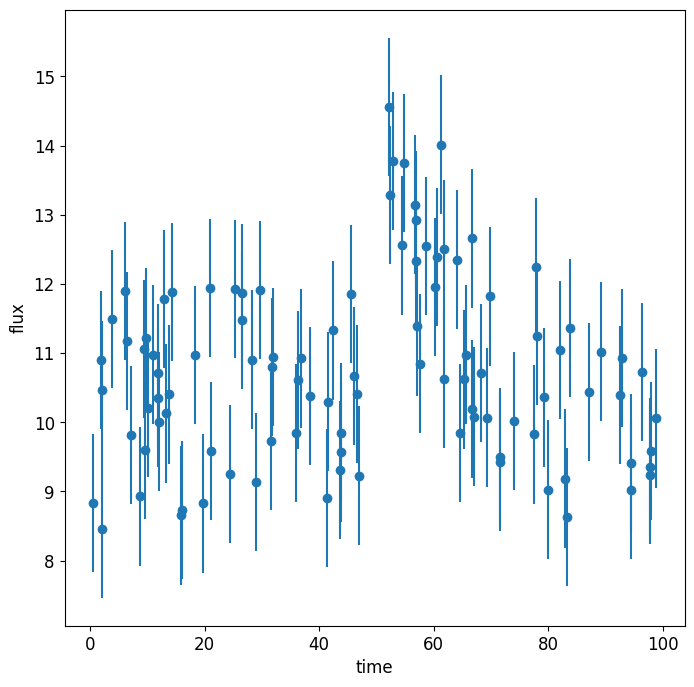

In [3]:
t,y,yerr=data.T
plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux");

These are the old burst model and the new gaussian profile model:

In [4]:
def burst(theta,t):
    A,b,t0,alpha=theta 
    return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))


def gprofile(theta,t):
    A,b,t0,sigmaW=theta     
    return b+A*np.exp(-(((t-t0)/sigmaW)**2 ) / 2)


t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)
sigmaWmin,sigmaWmax=np.exp(-2),np.exp(2)



First, let's reproduce our previous results using dynesty

In [5]:
# Define the dimensionality of our problem.
ndim = 4

def loglike(theta, data, model):
    x, y, sigma_y = data.T
    if model =='burst':
        y_fit = burst(theta, x)
    elif model == 'gprofile':
        y_fit = gprofile(theta, x)

    # Note I'm not tracking the normalization here! 
    # Ok because here I only care about the ratio between two evidences, not the evidence itself
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 


def ptform(u,model):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
   
    if model =='burst':
        x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    elif model =='gprofile':
        x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
        #x[3] = scipy.stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])

    return x

In [6]:
with warnings.catch_warnings():
    # Potentially dangerous, but hey I know what I'm doing. 
    # Those warnings come from regions where the likelihood is ~zero
    warnings.simplefilter("ignore", category=RuntimeWarning)


    # Define and run sampler
    sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data,'burst'],ptform_args=['burst'],nlive=300)
    sampler.run_nested()
    sresults = sampler.results

4730it [01:28, 53.54it/s, +300 | bound: 193 | nc: 1 | ncall: 97931 | eff(%):  5.152 | loglstar:   -inf < -48.765 <    inf | logz: -63.251 +/-  0.213 | dlogz:  0.001 >  0.309]


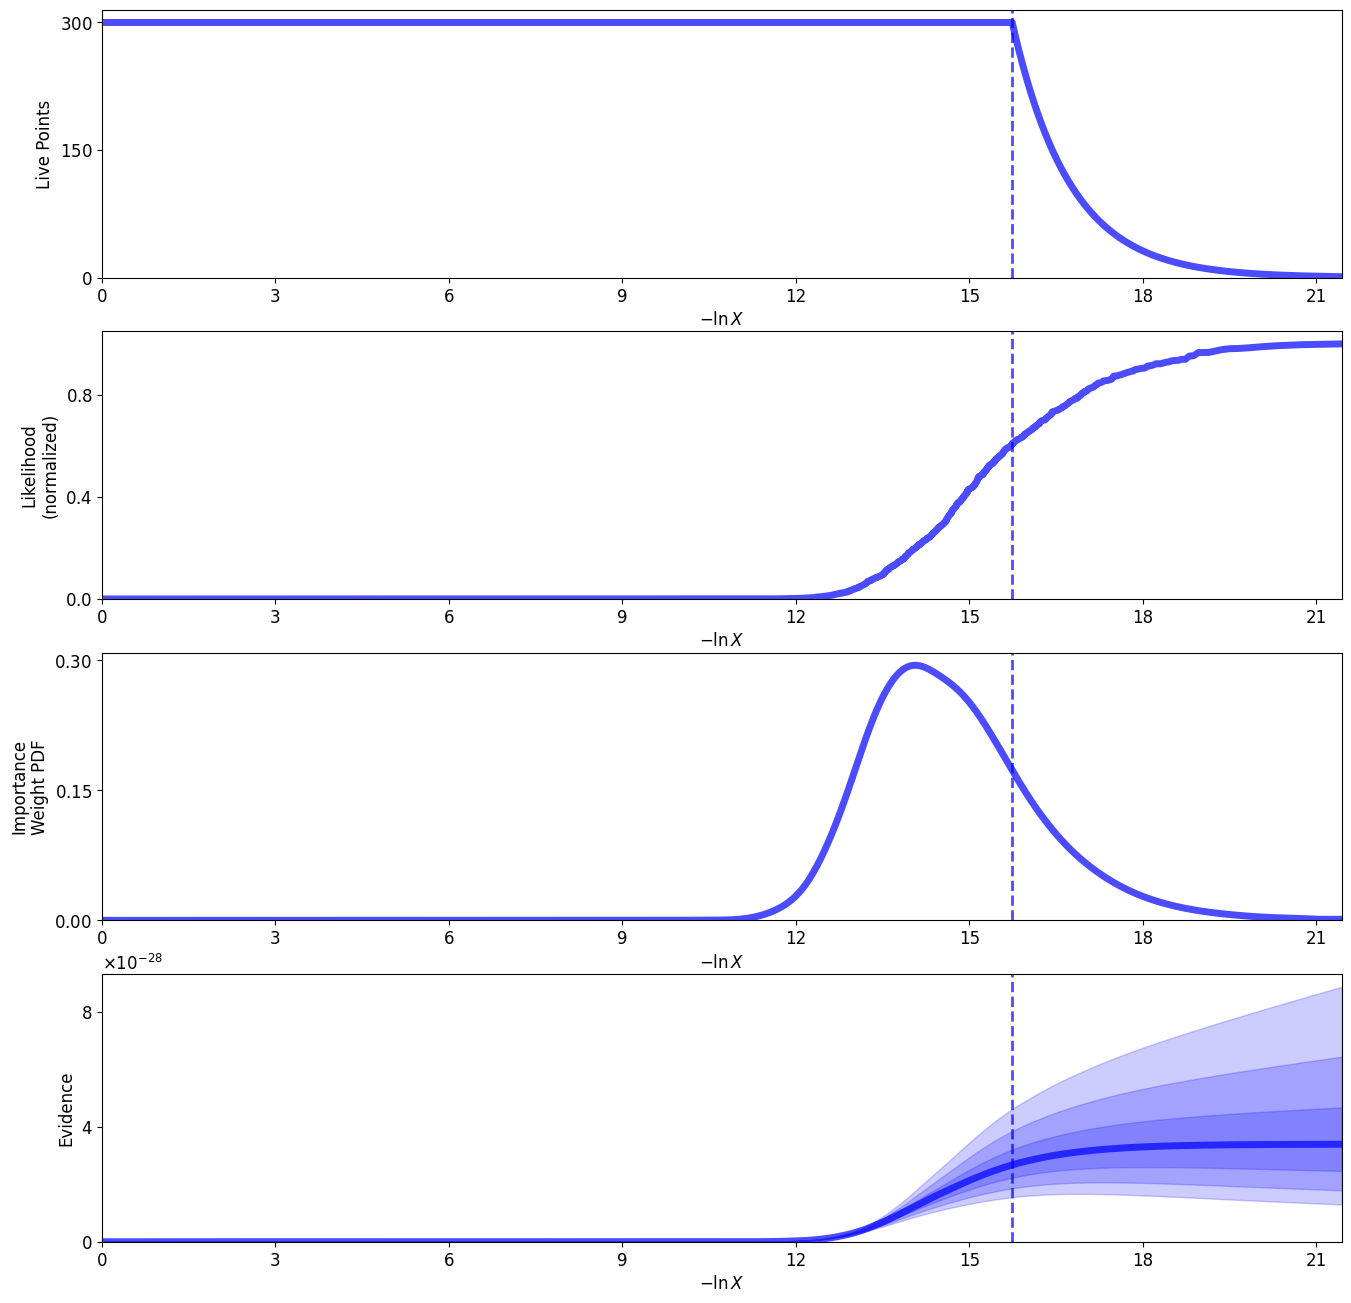

In [7]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

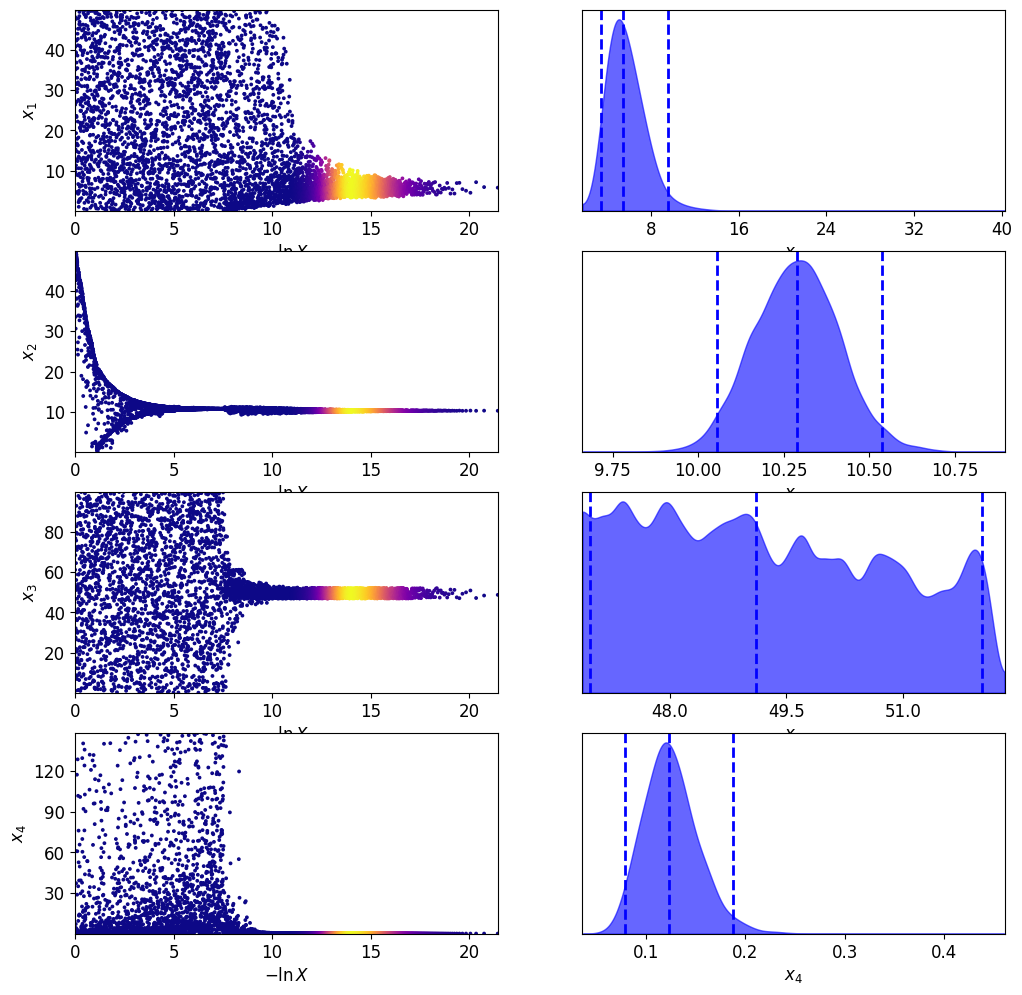

In [8]:
tfig, taxes = dyplot.traceplot(sresults)

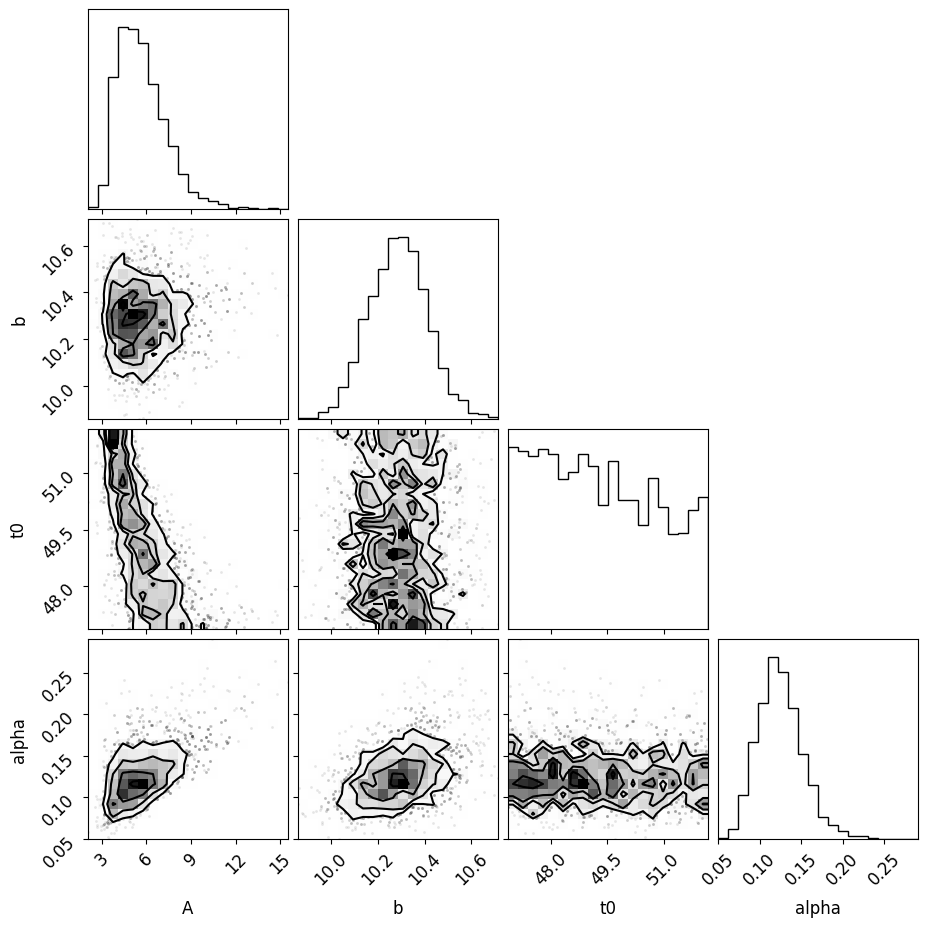

In [9]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

labels = ["A","b","t0","alpha"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [10]:
quantiles = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,labels):
    low,med,up=q
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))

A   5.4433004166299614 +3.134068871463926 -1.8575450199267465
b   10.288148682855159 +0.19710939036920827 -0.2040830440144159
t0   49.10929044509436 +2.7830783642585786 -2.0119123690317906
alpha   0.12280082311882559 +0.050452584292946134 -0.03821740423401124


In [11]:
sresults.summary()

Summary
nlive: 300
niter: 4730
ncall: 97631
eff(%):  5.152
logz: -63.251 +/-  0.321


Ok now let's move on with the Gaussian profile:

In [12]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data,'gprofile'],ptform_args=['gprofile'],nlive=300)
sampler.run_nested()
sresults2 = sampler.results


4869it [01:19, 60.92it/s, +300 | bound: 171 | nc: 1 | ncall: 87647 | eff(%):  5.918 | loglstar:   -inf < -52.451 <    inf | logz: -67.436 +/-  0.216 | dlogz:  0.001 >  0.309]


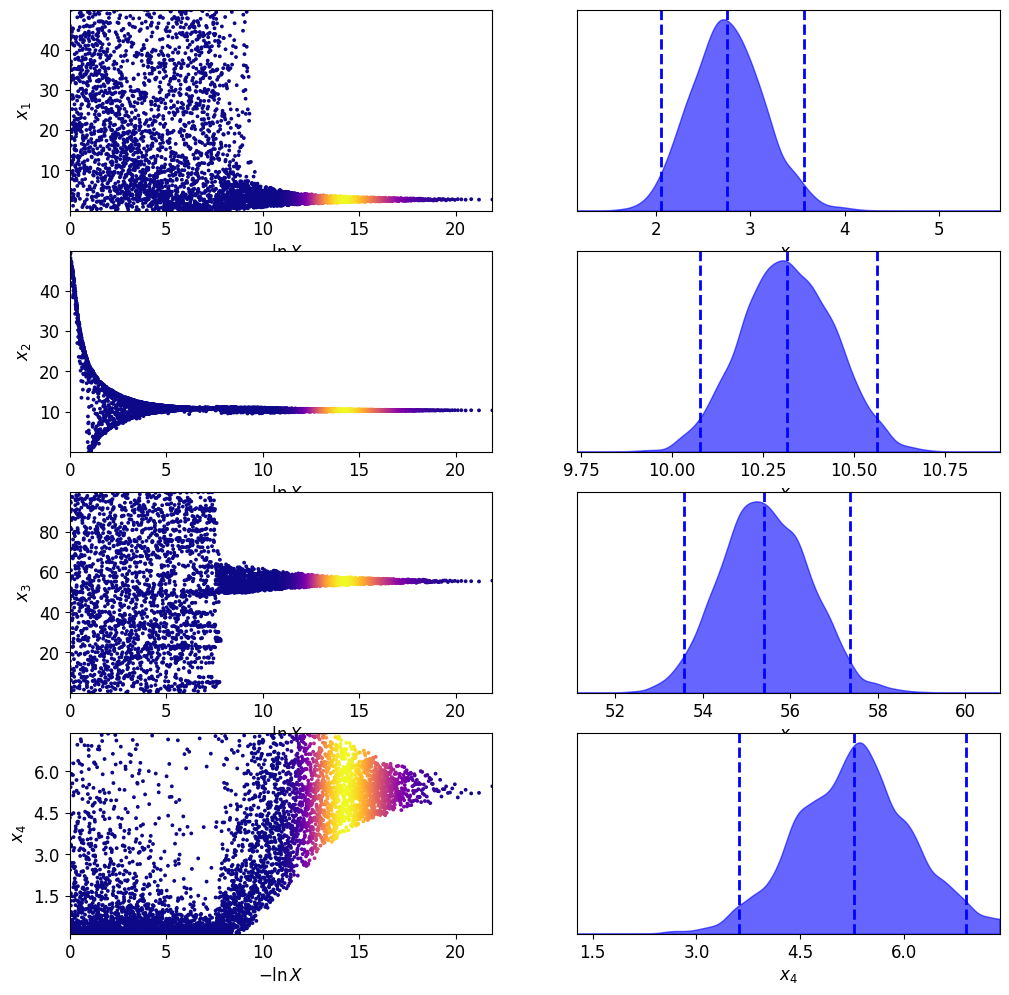

In [13]:
tfig, taxes = dyplot.traceplot(sresults2)

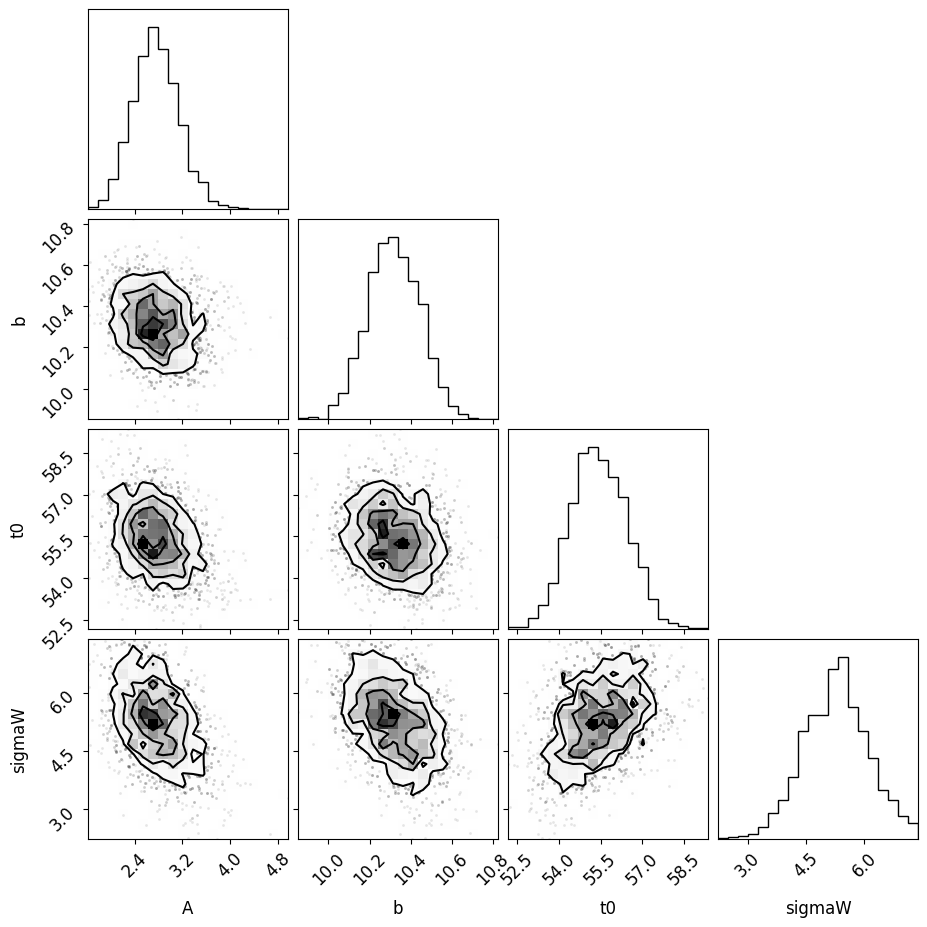

In [14]:
samples = sresults2.samples  # samples
weights = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights

labels = ["A","b","t0","sigmaW"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [15]:
sresults2.summary()

Summary
nlive: 300
niter: 4869
ncall: 87347
eff(%):  5.918
logz: -67.436 +/-  0.319


Now compute the odds ratio (assuming equal hyperpriors) between the two models:

In [16]:
np.exp(sresults.logz[-1])/np.exp(sresults2.logz[-1])

65.72908382462143

This is "very strong" evidence in favour of the burst model

Something I haven't done (but you should): 
- check if this number is robust with respect to the nested sampling hyperparameters (number of live points, dlogz threshold where the fit is terminated)
- Assign an error to this estimate of the Bayes factor.

Let's plot some models

Text(0, 0.5, 'flux')

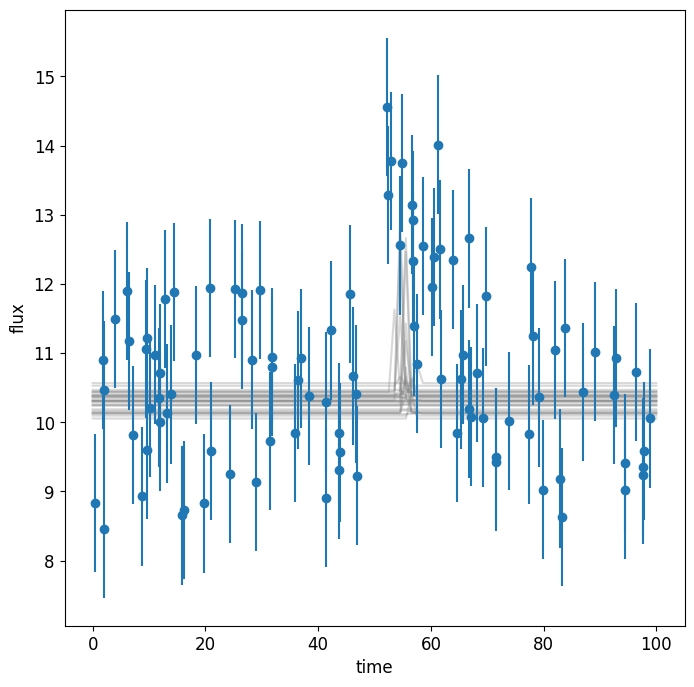

In [17]:
tgrid=np.linspace(0,100,100)

chosen_samples= samples_equal[np.random.choice(len(samples_equal),size=30)]

for chosen_theta in chosen_samples:

    ygrid =  burst(chosen_theta,tgrid)
    plt.plot(tgrid,ygrid,alpha=0.3,c='gray')
    
plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")

Indeed, look how badly this is describing the data... 

Remember this does not tell you that a model is correct, only that one is better than the other.

In [18]:
### Some tests I've done


### Here I played a bit with the fit by hand...
# tgrid=np.linspace(0,100,100)
# t0_quick=50
# A_quick=5
# b_quick=10
# sigmaW_quick=2
# theta_quick= np.array([A_quick,b_quick,t0_quick,sigmaW_quick])
# ygrid =  gprofile(theta_quick,tgrid)
# plt.errorbar(t,y,yerr=yerr,fmt='o')
# plt.xlabel("time")
# plt.ylabel("flux")
# plt.plot(tgrid,ygrid)

In [19]:
### Some tests I've done

### Here I convinced myself I understand what ppf is doing

# def ptform(u,model):
#     """Transforms the uniform random variables `u ~ Unif[0., 1.)`
#     to the parameters of interest."""
# 
#     x = np.array(u)  # copy u
# 
#     x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
#     x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
#     x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
# 
#     if model =='burst':
#         x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
#     elif model =='gprofile':
#         x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
#         #x[3] = scipy.stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])
# 
#     return x

# myu= np.random.uniform(0,1,4000).reshape(4,1000)
# myp = ptform(myu, 'burst')
# plt.hist(np.log(myp[3]))
# y=scipy.stats.loguniform.ppf(np.random.uniform(0,1,1000),sigmaWmin,sigmaWmax)
# plt.hist(np.log(y))